# Build TAO model

In [1]:
import orsa
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.8.5


In [2]:
model = orsa.model.Model(parameters = [], E_eval = np.arange(0.5, 10, 0.01), E_fit_min=0.8, E_fit_max=11, oscillation=orsa.oscillation.load(), detector=orsa.detector.load(), use_gpu=False, use_shape_uncertainty=True, rebin = 1, exposure = 1)


model.add_parameter(orsa.model.DetectorParameter(label = 'eff', value = 1,         group = 'tao', error = 0.01,   prior = {'positive': None},   formatted_label = r'$\epsilon$'))
model.add_parameter(orsa.model.ResolutionParameter(label = 'a',   value = 0.02614,   group = 'tao',  error = 0.0077, prior = {'positive': None},   formatted_label = r'$a$'))
model.add_parameter(orsa.model.ResolutionParameter(label = 'b',   value = 0.006401,  group = 'tao',  error = 0.012,  prior = {'positive': None},   formatted_label = r'$b$'))
model.add_parameter(orsa.model.ResolutionParameter(label = 'c',   value = 0.01205,   group = 'tao',  error = 0.033,  prior = {'positive': None},   formatted_label = r'$c$'))
model.add_parameter(orsa.model.NonLinearityParameter(label = 'a0',  value = 0,       group = 'shared',    error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_0$'))
model.add_parameter(orsa.model.NonLinearityParameter(label = 'a1',  value = 0,       group = 'shared',    error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_1$'))
model.add_parameter(orsa.model.NonLinearityParameter(label = 'a2',  value = 0,       group = 'shared',    error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_2$'))
model.add_parameter(orsa.model.NonLinearityParameter(label = 'a3',  value = 0,       group = 'shared',    error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_3$'))

model.add_parameter(orsa.model.OscillationParameter(label = 'rho',      value = 2.45,       error = 0.06,   group = 'shared', prior = {'positive': None}, formatted_label = r'$\rho$'))
model.add_parameter(orsa.model.OscillationParameter(label = 'dm2_21',   value = model.oscillation.dm2_21,    error = np.inf,     group='shared'       ,           formatted_label = r'$\Delta m^2_{21}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 'dm2_31',   value = model.oscillation.dm2_31,  error = np.inf,           group='shared'   ,           formatted_label = r'$\Delta m^2_{31}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 's2_12',    value = model.oscillation.s2_12,      error = np.inf,         group='shared'    ,            formatted_label = r'$\sin^2 \theta_{12}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 's2_13',    value = model.oscillation.s2_13,     error = 0.0306,         group='shared'     ,           formatted_label = r'$\sin^2 \theta_{13}$'))


gen_dict = dict()
gen_dict['rea'] = orsa.generator.reactor('CI', True, xs=model.detector.crosssection, shape_uncertainty='tao', scale_shape_uncertainty=1)
# gen_dict['U'] = orsa.generator.geoneutrinos('238U', True, True, shape_uncertainty=0.05)
gen_dict['geo'] = orsa.generator.spe2gen(0.9*orsa.generator.geoneutrinos('238U', True, xs=model.detector.crosssection).get_spectrum(model.E_eval) + 0.3*orsa.generator.geoneutrinos('232Th', True, xs=model.detector.crosssection).get_spectrum(model.E_eval), shape_uncertainty=0.05)
gen_dict['lihe'] =  orsa.generator.common_inputs('Li9BkgHistogramAD', orsa.spectrum.ReconstructedSpectrum, True, shape_uncertainty=0.1)
gen_dict['acc'] =  orsa.generator.common_inputs('AccBkgHistogramAD', orsa.spectrum.ReconstructedSpectrum,True, shape_uncertainty=0)
gen_dict['fn'] = orsa.generator.common_inputs('TAOFnBkg', orsa.spectrum.ReconstructedSpectrum, True, ci_file= 'TAOInputs2021_11_29.root', shape_uncertainty=0.2)
gen_dict['alpha'] = orsa.generator.common_inputs('AlphaNBkgHistogramAD',  orsa.spectrum.ReconstructedSpectrum, True, shape_uncertainty=0.5)
gen_dict['glob'] = orsa.generator.common_inputs('OtherReactorSpectrum_L300km',  orsa.spectrum.ReconstructedSpectrum, True, shape_uncertainty=0.05)
gen_dict['atm'] = orsa.generator.common_inputs('AtmosphericNeutrinoModelGENIE2',  orsa.spectrum.ReconstructedSpectrum, True, shape_uncertainty=0.5) 
gen_dict['snf'] = orsa.generator.reactor_corrections('snf', 'CI', True, xs=model.detector.crosssection, shape_uncertainty=0 )
gen_dict['noneq'] = orsa.generator.reactor_corrections('noneq', 'CI', True, xs=model.detector.crosssection, shape_uncertainty=0 )


model.add_parameter(orsa.model.CoreParameter(label = 'TS-C1',  group = 'shared', value = 1, error = 0.008, formatted_label = r'$R_\mathrm{TS-C1}$', baseline = 0.030, power = 4.6))
model.add_parameter(orsa.model.CoreParameter(label = 'TS-C2',  group = 'shared', value = 1, error = 0.008, formatted_label = r'$R_\mathrm{TS-C2}$', baseline = 0.225, power = 4.6))

rea = 93626.39
offeq = 585.34
snf = 94476.75-94211.7

N_rea = 93626.39/(365.25*11/12*6)

fact_offeq = offeq/rea
fact_snf = snf/rea 

model.add_parameter(orsa.model.NormalizationParameter(label = 'rea',   group = 'tao', value = 2000,    generator = gen_dict['rea'],     error = 0.1,     is_oscillated=True, has_duty=True,      formatted_label = r'$N_\mathrm{rea}$'))
# model.add_parameter(orsa.model.NormalizationParameter(label = 'U',     value = 0.,     generator = gen_dict['U'],       error = 0.,                                           formatted_label = r'$N_\mathrm{U}$'))
# model.add_parameter(orsa.model.NormalizationParameter(label = 'Th',    value = 0.,     generator = gen_dict['Th'],      error = 0.,                                           formatted_label = r'$N_\mathrm{Th}$'))
model.add_parameter(orsa.model.NormalizationParameter(label = 'acc',  group = 'tao',  value = 155.,     generator = gen_dict['acc'],     error = 0.01,                                             formatted_label = r'$N_\mathrm{acc}$'))
model.add_parameter(orsa.model.NormalizationParameter(label = 'lihe',  group = 'tao', value = 54.,     generator = gen_dict['lihe'],    error = 0.2,                                              formatted_label = r'$N_\mathrm{Li/He}$'))
model.add_parameter(orsa.model.NormalizationParameter(label = 'fn',    group = 'tao', value = 92.,     generator = gen_dict['fn'],      error = 1.,                                               formatted_label = r'$N_\mathrm{fn}$'))
model.exposure = 6*365.25

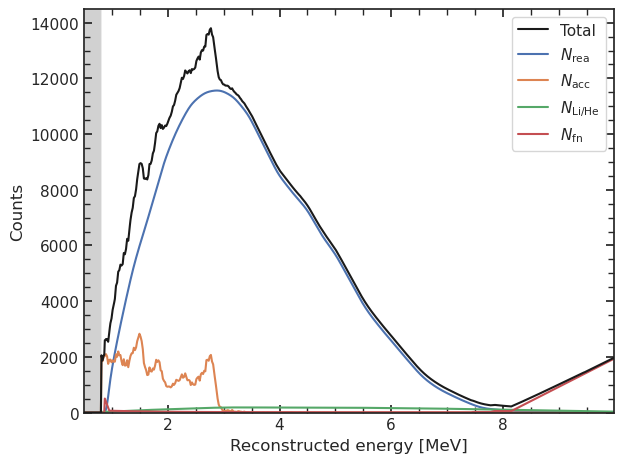

In [3]:
model # use model.to_json(filename) to store it to file

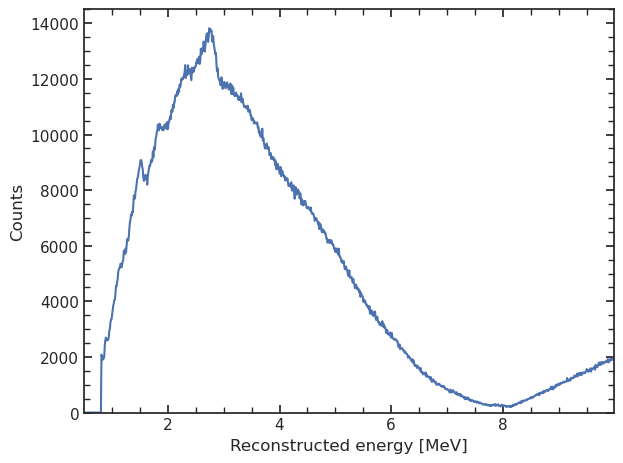

In [4]:
data = model.get_spectrum(asimov = False)
data

In [5]:
for param in model.oscillation_parameters:
    model.oscillation_parameters[param].fixed = True

for param in model.detector_parameters:
    model.detector_parameters[param].fixed = False

In [6]:
init_model = model.copy()
model.use_shape_uncertainty = False
cf = orsa.probability.CostFunction(ll=orsa.probability.chi2, model=model, data=data, ll_args = dict(which = 'C'))
true_values = cf.get_params_to_fit()[0]
res = orsa.fit.minuit(cf)
res.true_values = true_values

Cost function parsed as chi2-like


In [7]:
res.obj

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8205                       │              Nfcn = 321              │
│ EDM = 8.72e-05 (Goal: 0.0002)    │            time = 1.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ eff:tao      │  1.0003   │  0.0005   │            │            │         │         │       │
│ 1 │ a:tao        │ 26.13e-3  │  0.20e-3  │            │            │         │         │       │
│ 2 │ b:tao        │  6.40e-3  │  0.08e-3  │            │            │         │         │       │
│ 3 │ c:tao        │  12.0e-3  │  0.4e-3   │            │            │         │         │       │
│ 4 │ a0:shared    │    0.2    │    0.7    │            │            │         │         │       │
│ 5 │ a1:shared    │    0.0    │    0.5    │            │            │         │         │       │
│ 6 │ a2:shared    │   -0.2    │    0.3    │            │            │         │         │       │
│ 7 │ a3:shared    │   -0.0    │    0.5    │            │            │         │         │       │
│ 8 │ TS-C1:shared │  1.0003   │  0.0005   │            │            │         │         │       │
│ 9 │ TS-C2:shared │   1.000   │   0.008   │            │            │         │         │       │
│ 10│ rea:tao      │ 4.0196e6  │ 0.0023e6  │            │            │         │         │       │
│ 11│ acc:tao      │  338.1e3  │   1.6e3   │            │            │         │         │       │
│ 12│ lihe:tao     │  116.7e3  │   2.3e3   │            │            │         │         │       │
│ 13│ fn:tao       │  201.7e3  │   0.5e3   │            │            │         │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│              │       eff:tao         a:tao         b:tao         c:tao     a0:shared     a1:shared     a2:shared     a3:shared  TS-C1:shared  TS-C2:shared       rea:tao       acc:tao      lihe:tao        fn:tao │
├──────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│      eff:tao │      2.69e-07             0          0e-9             0      52.63e-6      -9.73e-6     -18.98e-6       0.06e-6            -0      -0.34e-6   -8.99305e-3 -266.37495e-3 -474.11857e-3   47.00819e-3 │
│        a:tao │             0      4.02e-08         -0e-9            -0       0.68e-6       0.49e-6      -0.11e-6       1.35e-6             0             0    3.13702e-3   -6.04959e-3   -7.47543e-3     815.23e-6 │
│        b:tao │          0e-9         -0e-9       5.9e-09         -0e-9        -12e-9         58e-9        -12e-9         46e-9          0e-9         -0e-9    465.439e-6   -606.487e-6  -1.098142e-3    100.744e-6 │
│        c:tao │